In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import sklearn
import brainiak
import nilearn as nl
from nilearn import image, plotting, input_data

from scipy.spatial import distance

from utils import *

- look at lTPJ and rPFC

In [52]:
WED_NUMS = [1,2,6,17,19,20,22,23,28,29,34,38]
[len(i) for i in ROI_NAME_L]

[24, 25, 25, 25, 25, 25, 17, 17, 15]

In [3]:
def load_sub_roi(sub_n,roi_name):
  """ TR x vox
  """
  fpath = "sub-%i_%s.npy"%(sub_n,roi_name)
  return np.load('fmri_data/masked/'+fpath)

def load_group_roi(roi_name):
  L = []
  for sub_n in SUB_NS:
    sub_roi = load_sub_roi(sub_n,roi_name)
    print(sub_roi.shape)
    L.append(sub_roi)
  return np.array(L)

def load_timing(sub_num):
  """returns df{wed_num:onset,offset}"""
  fpath = 'exp_info/%i/recall1stimulusInfo.csv'%sub_num
  df = pd.read_csv(fpath,index_col=3).iloc[:,1:]
  df.index = df.index.astype('int')
  df = df.astype('int')
  return df



//anaconda3/envs/brain/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'N=9 subs, 12 weddings each \nrhippocampusAAL')

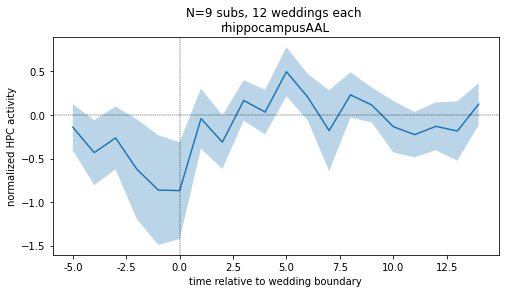

In [4]:
roi_name = 'rhippocampusAAL'
sub_hpcL = []
for sub_num in SUB_NS:
  roi = load_sub_roi(sub_num,roi_name)
  timing = load_timing(sub_num)
  for t in timing.onsets:
    sub_hpc = roi[int(t-5):int(t+15),:].mean(1)
    if len(sub_hpc):
      sub_hpcL.append(sub_hpc)

plt.figure(figsize=(8,4))
group_hpc = np.array(sub_hpcL)
Mhpc = group_hpc.mean(0)
Shpc = group_hpc.std(0)/np.sqrt(len(sub_hpcL))
ax = plt.gca()
ax.plot(Mhpc)
ax.fill_between(range(len(Mhpc)),Mhpc-Shpc,Mhpc+Shpc,alpha=.3)
ax.set_xticklabels(np.arange(-7.5,16,2.5))
ax.axhline(0,c='k',ls='--',lw=.4)
ax.axvline(5,c='k',ls='--',lw=.4)
ax.set_ylabel('normalized HPC activity')
ax.set_xlabel('time relative to wedding boundary')
ax.set_title('N=9 subs, 12 weddings each \n%s'%roi_name)
# plt.savefig('figures/'+'wedd_boundary-%s'%roi_name)

In [136]:
np.corrcoef([0,0],[0,0])

//anaconda3/envs/brain/lib/python3.6/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


array([[nan, nan],
       [nan, nan]])

In [141]:
def load_roi_boundary(sub_num=33,roi_name='rhippocampusAAL',wed_num=28,plust=15,minust=5,boundary_type='offsets'):
  """ 
  returns mean normalized roi actvity around boundary of wed_num
  TR x vox
  """
  timing_df = load_timing(sub_num)
  boundary_t = timing_df.loc[wed_num,boundary_type]
  roi = load_sub_roi(sub_num,roi_name)
  roi_boundary = roi[boundary_t-minust:boundary_t+plust,:].mean(-1)
  return roi_boundary

def load_boundary_df(subL=[33,34],roiL=['rhippocampusAAL','rsherlockAvg_fc_thr5_rTPJ'],wedL=WED_NUMS[-4:-3]):
  """
  dataframe with activation around trial boundary
  """
  sub_dfL = []
  for sub_num,roi_name,wed_num in itertools.product(subL,roiL,wedL):
    sub_df = pd.DataFrame(columns=['sub_num','roi_name','wed_num','boundary_time','roi_act'])
    roi_bound_act = load_roi_boundary(sub_num,roi_name,wed_num)
    if not len(roi_bound_act): 
      roi_bound_act = np.zeros(20)
      continue
    sub_df.roi_act = roi_bound_act
    sub_df.boundary_time = np.arange(-5,15,1)
    sub_df.sub_num = sub_num
    sub_df.wed_num = wed_num
    sub_df.roi_name = roi_name 
    sub_dfL.append(sub_df)
  boundary_df = pd.concat(sub_dfL)
  return boundary_df


In [142]:
boundary_df = load_boundary_df(subL=SUB_NS,roiL=ROI_NAME_L[:-1],wedL=WED_NUMS)
## mean over wedding nums
boundary_df2 = boundary_df.groupby(['sub_num','roi_name','boundary_time']).mean().drop('wed_num',1)
# 
boundary_df3 = boundary_df2.unstack('roi_name')

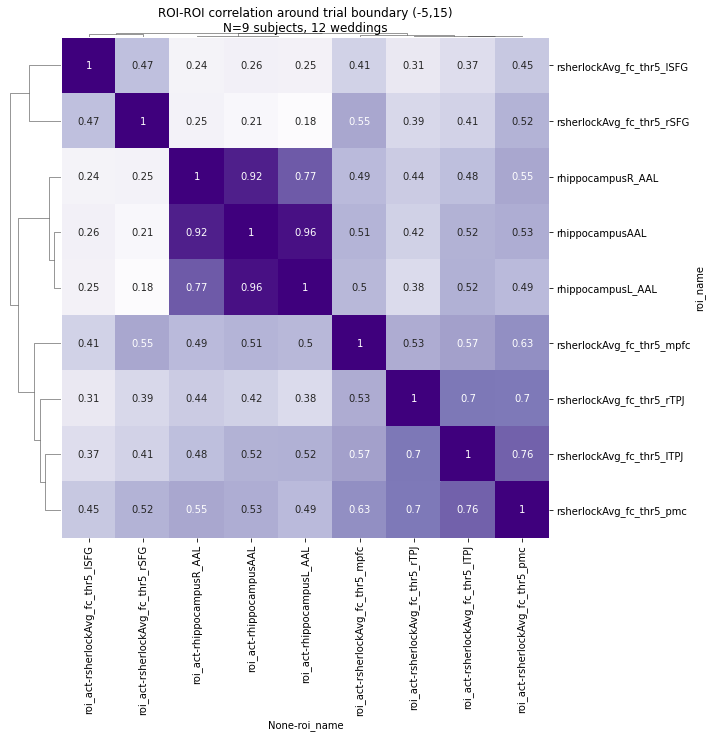

In [304]:
sub_rdm_df = boundary_df3.groupby('sub_num').corr()
sub_rdm_df.index = sub_rdm_df.index.droplevel(1)
Mrdm_df = sub_rdm_df.groupby('roi_name').mean()
N = sub_rdm_df.index.get_level_values('sub_num').unique()
Srdm_df = sub_rdm_df.groupby('roi_name').std()/np.sqrt(N)
import seaborn as sns

# plt.figure(figsize=(15,15))
sns.clustermap(Mrdm_df,annot=True,cmap='Purples',cbar_pos=None,figsize=(10,10),dendrogram_ratio=(.1,0.01))
plt.title('ROI-ROI correlation around trial boundary (-5,15)\nN=9 subjects, 12 weddings',y=1)
plt.savefig('figures/boundary_roiroiRDM')

# HPC plots

In [80]:
def load_hpc(max_tsteps=1100):
  L = []
  for sub_n in SUB_NS:
    sub_hpc = load_sub_roi(sub_n,ROI_NAME_L[-1])[:max_tsteps,:].mean(1)
    L.append(sub_hpc)
  return np.array(L)

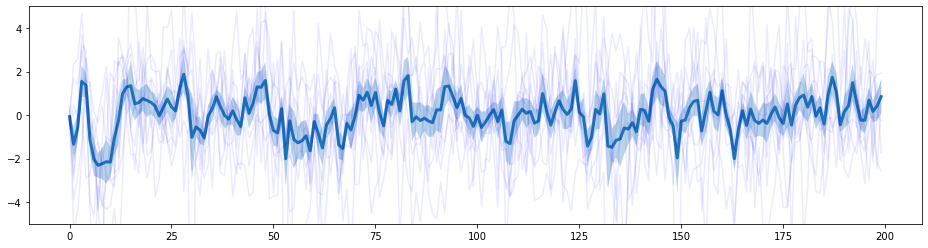

In [100]:
tsteps = 200
group_hpc = load_hpc(max_tsteps=tsteps)
M = group_hpc.mean(0)
S = group_hpc.std(0)/np.sqrt(len(SUB_NS))
# plot
plt.figure(figsize=(16,4))
plt.plot(M,lw=3)
plt.fill_between(range(tsteps),M-S,M+S,alpha=.3)

for sub_hpc in group_hpc:
  plt.plot(sub_hpc,alpha=.08,c='b')

plt.ylim(-5,5)

plt.savefig('figures/meanHPC')

# Time RSA

In [61]:
fig_len = 400
for roi_name in ROI_NAME_L:
  for sub_n in SUB_NS:
    print(roi_name,sub_n)
    sub_roi = load_sub_roi(sub_n,roi_name)[20:fig_len,:]
    # rsa
    cormat = 1-distance.cdist(sub_roi,sub_roi,metric='correlation')
    # plt
    plt.figure(figsize=(50,50))
    ax = plt.gca()
    for pltline in range(0,fig_len,100):
      ax.axvline(pltline,c='k',lw=4)
      ax.axhline(pltline,c='k',lw=4)
    plt.title('%s-sub-%i'%(roi_name,sub_n))
    ax.imshow(cormat,cmap='seismic',vmin=-1,vmax=1)
    plt.savefig('figures/timeRSA/viewingRSA/sub-%i_%s'%(sub_n,roi_name))
    plt.savefig('figures/timeRSA/viewingRSA/%s_sub-%i'%(roi_name.split('-')[-1],sub_n))
    plt.close('all')


rsherlockAvg_fc_thr5_rTPJ 30
rsherlockAvg_fc_thr5_rTPJ 31
rsherlockAvg_fc_thr5_rTPJ 32
rsherlockAvg_fc_thr5_rTPJ 33
rsherlockAvg_fc_thr5_rTPJ 34
rsherlockAvg_fc_thr5_rTPJ 35
rsherlockAvg_fc_thr5_rTPJ 36
rsherlockAvg_fc_thr5_rTPJ 37
rsherlockAvg_fc_thr5_rTPJ 38
rsherlockAvg_fc_thr5_pmc 30
rsherlockAvg_fc_thr5_pmc 31
rsherlockAvg_fc_thr5_pmc 32
rsherlockAvg_fc_thr5_pmc 33
rsherlockAvg_fc_thr5_pmc 34
rsherlockAvg_fc_thr5_pmc 35
rsherlockAvg_fc_thr5_pmc 36
rsherlockAvg_fc_thr5_pmc 37
rsherlockAvg_fc_thr5_pmc 38
rsherlockAvg_fc_thr5_rSFG 30
rsherlockAvg_fc_thr5_rSFG 31
rsherlockAvg_fc_thr5_rSFG 32
rsherlockAvg_fc_thr5_rSFG 33
rsherlockAvg_fc_thr5_rSFG 34
rsherlockAvg_fc_thr5_rSFG 35
rsherlockAvg_fc_thr5_rSFG 36
rsherlockAvg_fc_thr5_rSFG 37
rsherlockAvg_fc_thr5_rSFG 38
rsherlockAvg_fc_thr5_lSFG 30
rsherlockAvg_fc_thr5_lSFG 31
rsherlockAvg_fc_thr5_lSFG 32
rsherlockAvg_fc_thr5_lSFG 33
rsherlockAvg_fc_thr5_lSFG 34
rsherlockAvg_fc_thr5_lSFG 35
rsherlockAvg_fc_thr5_lSFG 36
rsherlockAvg_fc_thr5_lS